# Data Fitting, Covariance, and Confidence Levels

In [1]:
%matplotlib inline
# All imports
from random import choice
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import scipy.optimize as sp #import for curve_fit function
from scipy.optimize import curve_fit

import scipy.stats
import mpl_toolkits.mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

np.set_printoptions(formatter={'float': '{:.3f}'.format})

In Homework 1, you fitted the following two models:

$$ymodel1= \sin(kx+ φ) $$

$$ ymodel2=c0 + c1x + c2x2 + c3x3 + c4x4 + c5x5 + c6x6 + c7x7 + c8x8 $$

to simulated data using scipy.optimize.curve_fit(). Recall that the fitting parameters
are k and φ for model 1, and {ci} for model 2.

You have learned that curve_fit not only finds the best-fit parameters but also the variance associated with each fitting parameter as well as the covariance between them (the variancecovariance matrix, or the covariance matrix for short). You will see that the off-diagonal elements of the covariance matrix are typically non-zero. This means all the fitting parameters are “correlated” (either positively or negatively), that is, to a certain extent you can trade one parameter for another and maintain the quality of the fit.

In this homework you will start with your best-fit parameters.

## Part I
### Model 1

In [2]:
def sinusoid(x, k, phi):
    return np.sin((k*x) + phi)

### a) Print the best-fit parameters and the covariance matrix, with proper formatting:

In [3]:
N = 101
k = 2.
phi = np.pi/6.  #0.5235
measerr = 1/5
floorerr = 0.1
totalerr=np.sqrt((measerr**2) + (floorerr**2)) #0.2236

x = np.linspace(0, 2*np.pi, N)
y_noise = totalerr * np.random.normal(size=x.size)
ymodel1 = sinusoid(x, k, phi)
y = ymodel1 + measerr
y_data = ymodel1 + y_noise

best_fit_sinusoid, pcov_sinusoid = curve_fit(sinusoid, x, y_data, p0=[k, phi], maxfev=10000)

print('Best-fit coefficients: \n', best_fit_sinusoid)
print('Covariance matrix: \n', pcov_sinusoid)

Best-fit coefficients: 
 [2.003 0.527]
Covariance matrix: 
 [[0.000 -0.001]
 [-0.001 0.004]]


### b) Find the uncertainties for k and φ.

In [4]:
#best_fit_sinusoid gives the best-fit k and phi
k_best = best_fit_sinusoid[0]
phi_best = best_fit_sinusoid[1]
print('Best-fit k and phi, respectively: {:.3f} {:.3f}'.format(k_best, phi_best))

# The diagonal elements of the covariance matrix are the variances of the two fitting parameters.
k_uncertainty = np.sqrt(pcov_sinusoid[0, 0])
phi_uncertainty = np.sqrt(pcov_sinusoid[1, 1])
print('The best parameters are:')
print('k = {:.3f}'.format(k_best), '+/- {:.3f}'.format(k_uncertainty))
print('phi = {:.3f}'.format(phi_best), '+/- {:.3f}'.format(phi_uncertainty))

Best-fit k and phi, respectively: 2.003 0.527
The best parameters are:
k = 2.003 +/- 0.017
phi = 0.527 +/- 0.066


### c) Plot the PDF and CDF for k and φ, in 2-d (“heat maps”) and 3-d. 
### Show confidence contours for 1-, 2-, and 3-σ on the 2-d CDF, and indicate them as such. Give each figure an appropriate title (CDF or PDF).

In [5]:
def compute_cdf(P):
    """
    Input: probability distribution (PDF)
    Returns: CDF

    Adopted from: 

    https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
    """
    
    # save the original shape
    shape_orig = P.shape
    # this flattens the array.
    P = P.ravel()   
    
    # obtain the indices to sort and unsort the flattened array
    # i_sort will sort L in descending order
    i_sort = np.argsort(P)[::-1]
    i_unsort = np.argsort(i_sort)
    
    P_cumsum = P[i_sort].cumsum()
    # normalization
    P_cumsum /= P_cumsum[-1]
    
    return P_cumsum[i_unsort].reshape(shape_orig)

In [6]:
sig1, sig2, sig3 = 0.683, 0.955, 0.997
contour_levels = [sig1, sig2, sig3]

k_wid = k_uncertainty*5
phi_wid = phi_uncertainty*5

k_true = k
phi_true = phi

k_start, k_end = k_true - k_wid, k_true + k_wid #1.994 and 2.005
phi_start, phi_end = phi_true - phi_wid, phi_true + phi_wid #.501, .546

extent = [k_start, k_end, phi_start, phi_end]

k_steps = 101
phi_steps = 101

k_arr = np.linspace(k_start, k_end, k_steps)
phi_arr = np.linspace(phi_start, phi_end, phi_steps)

chi2_2d = np.zeros((k_steps, phi_steps))

xx, yy = np.mgrid[k_start:k_end:0.001, phi_start:phi_end:0.001]
# Create a grid of 2d coordinates 
xy = np.dstack((xx, yy))

# create a 2d Gaussian according to the best-fit (m, b) and the covariance matrix.
gauss2d = multivariate_normal(best_fit_sinusoid, pcov_sinusoid)
# gauss2d = multivariate_normal([k_best, phi_best], [[pcov_sinusoid[0][0], pcov_sinusoid[0][1]],[pcov_sinusoid[1][0], pcov_sinusoid[1][1]]])
PDF = gauss2d.pdf(xy)
# Normalize probability
PDF = PDF / PDF.sum()

CDF_grid = compute_cdf(PDF)

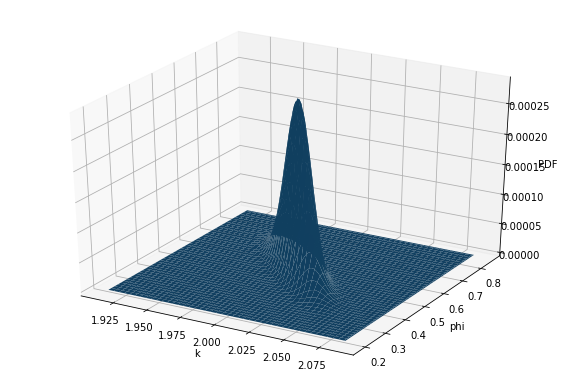

In [7]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(211, projection='3d')
ax.plot_surface(xx, yy, PDF)
ax.set_xlabel('k')
ax.set_ylabel('phi')
ax.set_zlabel('PDF')
plt.show()

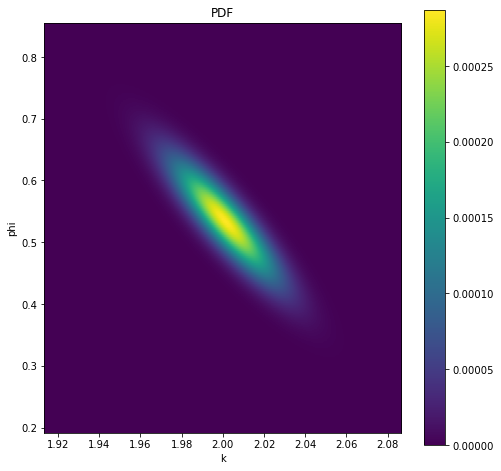

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(PDF, extent=extent, origin='lower')
# CS = plt.contour(PDF, levels=contour_levels, linestyles=['--','--','--'], extent = extent, cmap='Reds')
fig.colorbar(im_ax)
ax.set_aspect(.3)
# plt.xlim(k_start, k_end)
# plt.ylim(phi_start, phi_end)
plt.xlabel('k')
plt.ylabel('phi')
# plt.plot(k, phi, 'x', c='r', label='Best-fit value ( {:2f}'.format(k_best)+' , {:2f}'.format(phi_best)+')')
# plt.legend()
# plt.plot(k_best, phi_best, 'x', c='r')
plt.title('PDF')
plt.show()

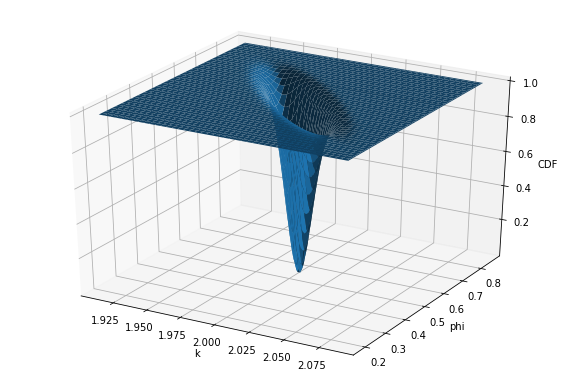

In [9]:
CDF_ex = compute_cdf(PDF)
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(211, projection='3d')
ax.plot_surface(xx, yy, CDF_ex)
ax.set_xlabel('k')
ax.set_ylabel('phi')
ax.set_zlabel('CDF')
plt.show()

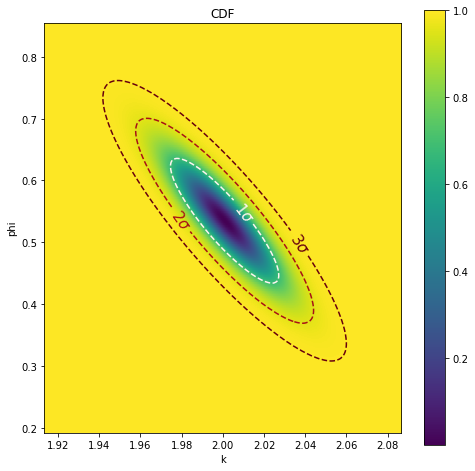

In [10]:
CDF_ex = compute_cdf(PDF)
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(CDF_ex, extent=extent, origin='lower')
CS = plt.contour(CDF_ex, levels=contour_levels, linestyles=['--','--','--'], extent = extent, cmap='Reds')
fig.colorbar(im_ax)
ax.set_aspect(0.3)
fmtdict = {sig1:r'$1\sigma$', sig2:r'$2\sigma$', sig3:r'$3\sigma$'}
plt.clabel(CS, fmt=fmtdict, inline=True, fontsize=15)

# plt.ylim(.2, .8)
# plt.xlim(1.9, 2.1)
# plt.plot(k, phi, 'x', c='r', label='Best-fit value ( {:2f}'.format(k_best)+' , {:2f}'.format(phi_best)+')')
plt.xlabel('k')
plt.ylabel('phi')
plt.title('CDF')
plt.show()

## Part II
### Model 2

In [11]:
def poly(x, c0, c1, c2, c3, c4, c5, c6, c7, c8):
    return c0 + c1*(x**1) + c2*(x**2) + c3*(x**3) + c4*(x**4) + c5*(x**5) + c6*(x**6) + c7*(x**7) + c8*(x**8)

### a) Print the best-fit parameters and the covariance matrix, with proper formatting:

In [15]:
measerr = 1/5
floorerr = 0.1
totalerr=np.sqrt((measerr**2) + (floorerr**2)) #0.2236

x = np.linspace(0, 2*np.pi, N)
ymodel1 = sinusoid(x, k, phi)

y_noise = totalerr * np.random.normal(size=x.size)
y_data = ymodel1 + y_noise

best_fit_poly, pcov_poly = curve_fit(poly, x, y_data, p0=(0,1, 0, (-1/5), 0, (1/120), 0, (-1/5000), 0))


modelPoly = poly(x, best_fit_poly[0], best_fit_poly[1], best_fit_poly[2], best_fit_poly[3], best_fit_poly[4], best_fit_poly[5], best_fit_poly[6], best_fit_poly[7], best_fit_poly[8])

print('Best-fit polynomial coefficients: \n', best_fit_poly)
print('Covariance matrix: \n', pcov_poly)

Best-fit polynomial coefficients: 
 [0.780 -1.078 7.647 -13.000 8.508 -2.710 0.450 -0.037 0.001]
Covariance matrix: 
 [[0.020 -0.124 0.251 -0.238 0.122 -0.036 0.006 -0.001 0.000]
 [-0.124 1.162 -2.748 2.832 -1.533 0.469 -0.082 0.008 -0.000]
 [0.251 -2.748 7.005 -7.559 4.223 -1.323 0.234 -0.022 0.001]
 [-0.238 2.832 -7.559 8.411 -4.805 1.530 -0.275 0.026 -0.001]
 [0.122 -1.533 4.223 -4.805 2.791 -0.900 0.163 -0.016 0.001]
 [-0.036 0.469 -1.323 1.530 -0.900 0.293 -0.054 0.005 -0.000]
 [0.006 -0.082 0.234 -0.275 0.163 -0.054 0.010 -0.001 0.000]
 [-0.001 0.008 -0.022 0.026 -0.016 0.005 -0.001 0.000 -0.000]
 [0.000 -0.000 0.001 -0.001 0.001 -0.000 0.000 -0.000 0.000]]


### b) For the fitting parameters c0 and c1, find their uncertainties.

In [16]:
#best_fit_sinusoid gives the best-fit coefficients
c0_best = best_fit_poly[0]
c1_best = best_fit_poly[1]
c2_best = best_fit_poly[2]
c3_best = best_fit_poly[3]
c4_best = best_fit_poly[4]
c5_best = best_fit_poly[5]
c6_best = best_fit_poly[6]
c7_best = best_fit_poly[7]
c8_best = best_fit_poly[8]
# print('Best-fit c0 and phi, respectively: {:.3f} {:.3f}'.format(c0_best, c1_best))

# The diagonal elements of the covariance matrix are the variances of the two fitting parameters.
c0_uncertainty = np.sqrt(pcov_poly[0, 0])
c1_uncertainty = np.sqrt(pcov_poly[1, 1])
c2_uncertainty = np.sqrt(pcov_poly[2, 2])
c3_uncertainty = np.sqrt(pcov_poly[3, 3])
c4_uncertainty = np.sqrt(pcov_poly[4, 4])
c5_uncertainty = np.sqrt(pcov_poly[5, 5])
c6_uncertainty = np.sqrt(pcov_poly[6, 6])
c7_uncertainty = np.sqrt(pcov_poly[7, 7])
c8_uncertainty = np.sqrt(pcov_poly[8, 8])
print('The best parameters are:')
print('c0 = {:.3f}'.format(c0_best), '+/- {:.3f}'.format(c0_uncertainty))
print('c1 = {:.3f}'.format(c1_best), '+/- {:.3f}'.format(c1_uncertainty))
print('c2 = {:.3f}'.format(c2_best), '+/- {:.3f}'.format(c2_uncertainty))
print('c3 = {:.3f}'.format(c3_best), '+/- {:.3f}'.format(c3_uncertainty))
print('c4 = {:.3f}'.format(c4_best), '+/- {:.3f}'.format(c4_uncertainty))
print('c5 = {:.3f}'.format(c5_best), '+/- {:.3f}'.format(c5_uncertainty))
print('c6 = {:.3f}'.format(c6_best), '+/- {:.3f}'.format(c6_uncertainty))
print('c7 = {:.3f}'.format(c7_best), '+/- {:.3f}'.format(c7_uncertainty))
print('c8 = {:.3f}'.format(c8_best), '+/- {:.3f}'.format(c8_uncertainty))

The best parameters are:
c0 = 0.780 +/- 0.140
c1 = -1.078 +/- 1.078
c2 = 7.647 +/- 2.647
c3 = -13.000 +/- 2.900
c4 = 8.508 +/- 1.670
c5 = -2.710 +/- 0.542
c6 = 0.450 +/- 0.099
c7 = -0.037 +/- 0.010
c8 = 0.001 +/- 0.000


### c) The covariance for this model provides pair-wise information. For example, cov[0, 1]
### tells you how c0 and c1 are correlated. Find the following for these three pairs of coefficients:
### • most positively correlated,
### • most negatively correlated (or anti-correlated), and
### • least correlated.

In [17]:
temp = pcov_poly.copy()
subArray = temp[0:7, 0:7]
subArray[0][0]=subArray[1][1]=subArray[2][2]=subArray[3][3]=subArray[4][4]=subArray[5][5]=subArray[6][6]=1

mostPos = subArray.max()
mostNeg = subArray.min()
least = np.abs(subArray).min()

mostPosidx=np.where(subArray == mostPos)
mostPosidx0, mostPosidx1 = mostPosidx[0][0], mostPosidx[1][0]
mostNegidx=np.where(subArray == mostNeg)
mostNegidx0, mostNegidx1 = mostNegidx[0][0], mostNegidx[1][0]
leastidx = np.where(subArray == least)
leastidx0, leastidx1 = leastidx[0][0], leastidx[1][0]

In [18]:
mostPosidx0, mostPosidx1, mostNegidx0, mostNegidx1, leastidx0, leastidx1

(4, 2, 3, 2, 0, 6)

In each case, 
• Plot the PDF and CDF for these three sets of parameters, only in 2-d. Each set should
have one figure and two subfigures, one for PDF and one for CDF.
• Show confidence contours for 1-, 2-, and 3-σ on the CDF, and indicate them as such.
• Give each (sub)figure an appropriate title: “PDF (or CDF): Most Positively
Correlated”, “PDF (or CDF): Most Negatively Correlated”, and “PDF (or CDF):
Least Correlated”)”.
• Print on the figures the names of the parameters and the covariance. You can use
plt.text(). Suppose c0 and c1 are the most correlated with a covariance of
0.05, then pint this information on the PDF and CDF:
cov(c1, c2) = 0.05
For the the covariance of the least correlated pair, please express it in scientific
notation (i.e., x.xexx).

### Most Positively Correlated

In [19]:
print('Most positively correlated = cov[', mostPosidx0, ',', mostPosidx1,'] -> {:3f}'.format(mostPos))        

Most positively correlated = cov[ 4 , 2 ] -> 4.223498


In [20]:
#best fit coefficients:
mostPos_popt=[best_fit_poly[mostPosidx0], best_fit_poly[mostPosidx1]]
#covariance matrix:             
mostPos_pcov = [[pcov_poly[mostPosidx0, mostPosidx0], pcov_poly[mostPosidx0, mostPosidx1]], [pcov_poly[mostPosidx0, mostPosidx1], pcov_poly[mostPosidx1, mostPosidx1]]]                         

In [89]:
mostPos_popt[0], mostPos_popt[1]

(9.607922467575147, 7.846208216753026)

In [23]:
mostPos0_wid = 6
mostPos1_wid = 6

mostPos0_start, mostPos0_end = mostPos_popt[0] - mostPos0_wid, mostPos_popt[0] + mostPos0_wid
mostPos1_start, mostPos1_end = mostPos_popt[1] - mostPos1_wid, mostPos_popt[1] + mostPos1_wid

mostPos0_arr = np.linspace(mostPos0_start, mostPos0_end, 1000)
mostPos1_arr = np.linspace(mostPos1_start, mostPos1_end, 1000)

mostPos_extent = [mostPos0_arr[0], mostPos0_arr[-1], mostPos1_arr[0], mostPos1_arr[-1]]

In [24]:
xxPos, yyPos = np.mgrid[mostPos0_start:mostPos0_end:0.001, mostPos1_start:mostPos1_end:0.001]
# Create a grid of 2d coordinates 
xyPos = np.dstack((xxPos, yyPos))

In [25]:
# create a 2d Gaussian according to the best-fit (m, b) and the covariance matrix.
gauss2d = multivariate_normal(mostPos_popt, mostPos_pcov)
# gauss2d = multivariate_normal([k_best, phi_best], [[pcov_sinusoid[0][0], pcov_sinusoid[0][1]],[pcov_sinusoid[1][0], pcov_sinusoid[1][1]]]

In [26]:
PDFPos = gauss2d.pdf(xyPos)
PDFPos = PDFPos / PDFPos.sum()

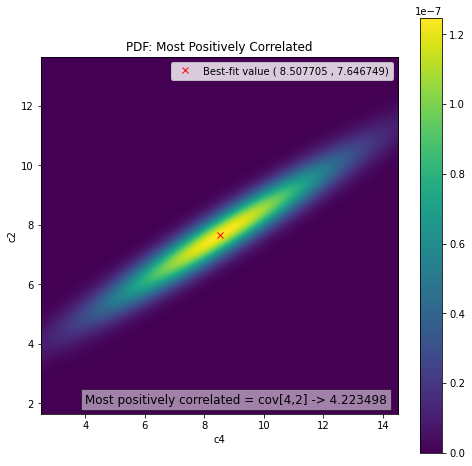

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(PDFPos, extent=mostPos_extent, origin='lower')
fig.colorbar(im_ax)
# ax.set_aspect(.8)
# plt.xlim(1.95, 2.10)
plt.xlabel('c'+str(mostPosidx0))
plt.ylabel('c'+str(mostPosidx1))
plt.plot(mostPos_popt[0], mostPos_popt[1], 'x', c='r', label='Best-fit value ( {:2f}'.format(mostPos_popt[0])+' , {:2f}'.format(mostPos_popt[1])+')')
plt.text(4, 2, 'Most positively correlated = cov['+ str(mostPosidx0)+ ','+ str(mostPosidx1)+'] -> {:3f}'.format(mostPos), bbox=dict(facecolor='white', alpha=0.5), fontsize=12)        
plt.title('PDF: Most Positively Correlated')
plt.legend()
plt.show()

In [28]:
CDFPos = compute_cdf(PDFPos)

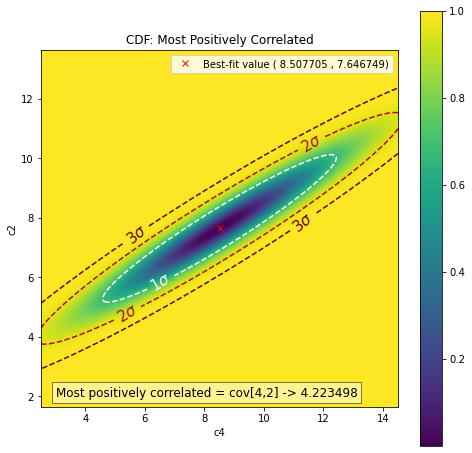

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(CDFPos, extent=mostPos_extent, origin='lower')
CS = plt.contour(CDFPos, levels=contour_levels, linestyles=['--','--','--'], extent = mostPos_extent, cmap='Reds')
fig.colorbar(im_ax)
fmtdict = {sig1:r'$1\sigma$', sig2:r'$2\sigma$', sig3:r'$3\sigma$'}
plt.clabel(CS, fmt=fmtdict, inline=True, fontsize=15)
# ax.set_aspect(.8)
# plt.ylim(.4, .6)
# plt.xlim(1.94, 2.12)
# plt.text()
plt.xlabel('c'+str(mostPosidx0))
plt.ylabel('c'+str(mostPosidx1))
plt.plot(mostPos_popt[0], mostPos_popt[1], 'x', c='r', label='Best-fit value ( {:2f}'.format(mostPos_popt[0])+' , {:2f}'.format(mostPos_popt[1])+')')
plt.text(3, 2, 'Most positively correlated = cov['+ str(mostPosidx0)+ ','+ str(mostPosidx1)+'] -> {:3f}'.format(mostPos), bbox=dict(facecolor='white', alpha=0.5), fontsize=12)        
plt.title('CDF: Most Positively Correlated')
plt.legend()
plt.show()

### Most Negatively Correlated

In [31]:
print('Most negatively correlated = cov[', mostNegidx0, ',', mostNegidx1,'] -> {:3f}'.format(mostNeg))

Most negatively correlated = cov[ 3 , 2 ] -> -7.558581


In [32]:
#best fit coefficients:
mostNeg_popt=[best_fit_poly[mostNegidx0], best_fit_poly[mostNegidx1]]
#covariance matrix:
mostNeg_pcov = [[pcov_poly[mostNegidx0, mostNegidx0], pcov_poly[mostNegidx0, mostNegidx1]], [pcov_poly[mostNegidx0, mostNegidx1], pcov_poly[mostNegidx1, mostNegidx1]]]

In [33]:
mostNeg0_wid = 7
mostNeg1_wid = 7

mostNeg0_start, mostNeg0_end = mostNeg_popt[0] - mostNeg0_wid, mostNeg_popt[0] + mostNeg0_wid
mostNeg1_start, mostNeg1_end = mostNeg_popt[1] - mostNeg1_wid, mostNeg_popt[1] + mostNeg1_wid

mostNeg0_arr = np.linspace(mostNeg0_start, mostNeg0_end, 1000)
mostNeg1_arr = np.linspace(mostNeg1_start, mostNeg1_end, 1000)

mostNeg_extent = [mostNeg0_arr[0], mostNeg0_arr[-1], mostNeg1_arr[0], mostNeg1_arr[-1]]


In [34]:
xxNeg, yyNeg = np.mgrid[mostNeg0_start:mostNeg0_end:0.001, mostNeg1_start:mostNeg1_end:0.001]
# Create a grid of 2d coordinates 
xyNeg = np.dstack((xxNeg, yyNeg))

In [35]:
# create a 2d Gaussian according to the best-fit (m, b) and the covariance matrix.
gauss2d = multivariate_normal(mostNeg_popt, mostNeg_pcov)
# gauss2d = multivariate_normal([k_best, phi_best], [[pcov_sinusoid[0][0], pcov_sinusoid[0][1]],[pcov_sinusoid[1][0], pcov_sinusoid[1][1]]]

In [36]:
PDFNeg = gauss2d.pdf(xyNeg)
PDFNeg = PDFNeg / PDFNeg.sum()

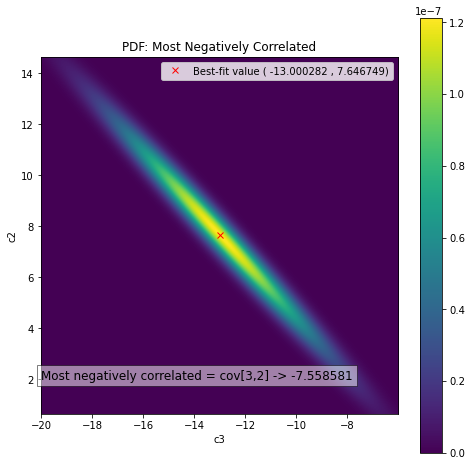

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(PDFNeg, extent=mostNeg_extent, origin='lower')
fig.colorbar(im_ax)
# ax.set_aspect(.8)
# plt.xlim(1.95, 2.10)
plt.xlabel('c'+str(mostNegidx0))
plt.ylabel('c'+str(mostNegidx1))
plt.plot(mostNeg_popt[0], mostNeg_popt[1], 'x', c='r', label='Best-fit value ( {:2f}'.format(mostNeg_popt[0])+' , {:2f}'.format(mostNeg_popt[1])+')')
plt.text(-20, 2, 'Most negatively correlated = cov['+ str(mostNegidx0)+ ','+ str(mostNegidx1)+'] -> {:3f}'.format(mostNeg), bbox=dict(facecolor='white', alpha=0.5), fontsize=12)        
plt.title('PDF: Most Negatively Correlated')
plt.legend()
plt.show()

In [38]:
CDFNeg = compute_cdf(PDFNeg)

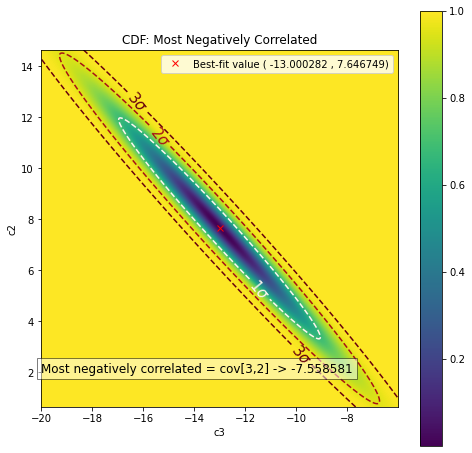

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(CDFNeg, extent=mostNeg_extent, origin='lower')
CS = plt.contour(CDFNeg, levels=contour_levels, linestyles=['--','--','--'], extent = mostNeg_extent, cmap='Reds')
fig.colorbar(im_ax)
fmtdict = {sig1:r'$1\sigma$', sig2:r'$2\sigma$', sig3:r'$3\sigma$'}
plt.clabel(CS, fmt=fmtdict, inline=True, fontsize=15)
# ax.set_aspect(1)
# plt.ylim(.4, .6)
# plt.xlim(1.94, 2.12)
# plt.text()
plt.xlabel('c'+str(mostNegidx0))
plt.ylabel('c'+str(mostNegidx1))
plt.plot(mostNeg_popt[0], mostNeg_popt[1], 'x', c='r', label='Best-fit value ( {:2f}'.format(mostNeg_popt[0])+' , {:2f}'.format(mostNeg_popt[1])+')')
plt.text(-20, 2, 'Most negatively correlated = cov['+ str(mostNegidx0)+ ','+ str(mostNegidx1)+'] -> {:3f}'.format(mostNeg), bbox=dict(facecolor='white', alpha=0.5), fontsize=12)        
plt.title('CDF: Most Negatively Correlated')
plt.legend()
plt.show()

### Least Correlated

In [40]:
print('Least correlated = cov[', leastidx0, ',', leastidx1,'] -> {:.8}'.format(least))

Least correlated = cov[ 0 , 6 ] -> 0.0061240175


In [41]:
#best fit coefficients:
least_popt=[best_fit_poly[leastidx0], best_fit_poly[leastidx1]]
#covariance matrix:
least_pcov = [[pcov_poly[leastidx0, leastidx0], pcov_poly[leastidx0, leastidx1]], [pcov_poly[leastidx0, leastidx1], pcov_poly[leastidx1, leastidx1]]]

In [42]:
least0_wid = .5
least1_wid = 1.5


least0_start, least0_end = least_popt[0] - least0_wid, least_popt[0] + least0_wid
least1_start, least1_end = least_popt[1] - least1_wid, least_popt[1] + least1_wid

least0_arr = np.linspace(least0_start, least0_end, 1000)
least1_arr = np.linspace(least1_start, least1_end, 1000)

least_extent = [least0_arr[0], least0_arr[-1], least1_arr[0], least1_arr[-1]]

In [43]:
xxLeast, yyLeast = np.mgrid[least0_start:least0_end:0.001, least1_start:least1_end:0.001]
# Create a grid of 2d coordinates 
xyLeast = np.dstack((xxLeast, yyLeast))

In [44]:
# create a 2d Gaussian according to the best-fit (m, b) and the covariance matrix.
gauss2d = multivariate_normal(least_popt, least_pcov)
# gauss2d = multivariate_normal([k_best, phi_best], [[pcov_sinusoid[0][0], pcov_sinusoid[0][1]],[pcov_sinusoid[1][0], pcov_sinusoid[1][1]]]

In [45]:
PDFLeast = gauss2d.pdf(xyLeast)
PDFLeast = PDFLeast / PDFLeast.sum()

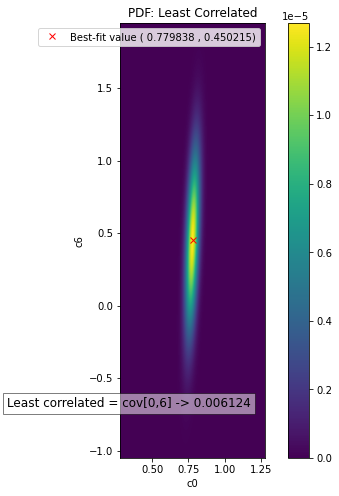

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(PDFLeast, extent=least_extent, origin='lower')
fig.colorbar(im_ax)
# ax.set_aspect(2)
# plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.xlabel('c'+str(leastidx0))
plt.ylabel('c'+str(leastidx1))
plt.plot(least_popt[0], least_popt[1], 'x', c='r', label='Best-fit value ( {:2f}'.format(least_popt[0])+' , {:2f}'.format(least_popt[1])+')')
plt.text(-.5, -.7, 'Least correlated = cov['+ str(leastidx0)+ ','+ str(leastidx1)+'] -> {:3f}'.format(least), bbox=dict(facecolor='white', alpha=0.5), fontsize=12)        
plt.title('PDF: Least Correlated')
plt.legend()
plt.show()

In [47]:
CDFLeast = compute_cdf(PDFLeast)

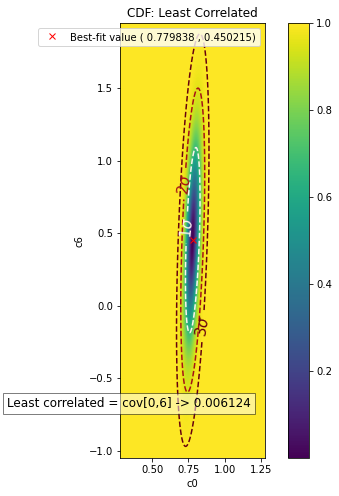

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
im_ax = plt.imshow(CDFLeast, extent=least_extent, origin='lower')
CS = plt.contour(CDFLeast, levels=contour_levels, linestyles=['--','--','--'], extent = least_extent, cmap='Reds')
fig.colorbar(im_ax)
# ax.set_aspect(1)
# plt.ylim(-2, 1)
# plt.xlim(1.94, 2.12)
# plt.text()
plt.xlabel('c'+str(leastidx0))
plt.ylabel('c'+str(leastidx1))
fmtdict = {sig1:r'$1\sigma$', sig2:r'$2\sigma$', sig3:r'$3\sigma$'}
plt.clabel(CS, fmt=fmtdict, inline=True, fontsize=15)
plt.plot(least_popt[0], least_popt[1], 'x', c='r', label='Best-fit value ( {:2f}'.format(least_popt[0])+' , {:2f}'.format(least_popt[1])+')')
plt.text(-.5, -.7, 'Least correlated = cov['+ str(leastidx0)+ ','+ str(leastidx1)+'] -> {:3f}'.format(least), bbox=dict(facecolor='white', alpha=0.5), fontsize=12)        
plt.title('CDF: Least Correlated')
plt.legend()
plt.show()